In [34]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
load_dotenv()

True

In [35]:
# model
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature = 0.7)

In [36]:
# Output Parser Schema

class SentimentSchema(BaseModel):

      sentiment : Literal["Positive", "Negative"] = Field(description = "Tells the sentiment of the rewiew, like if its positive or negative")


class DiagnosisSchame(BaseModel):

      issue_type: Literal["UI/UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
      tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
      urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [37]:
# model with structured output
model_with_structured_output = model.with_structured_output(SentimentSchema)

In [38]:
# model with structured output for Diagnosis Output
model_with_diagnosis_output = model.with_structured_output(DiagnosisSchame)

In [39]:
prompt = f'What is the sentiment of the following review - The software is so bad'
abc = model_with_structured_output.invoke(prompt)
abc.sentiment

'Negative'

In [40]:
# state

class ReviewState(TypedDict):

      review : str
      sentiment : Literal["Positive", "Negative"]

      diagnosis : dict
      response : str

In [41]:
def find_sentiment(state : ReviewState) -> ReviewState:

      prompt = f"What is the sentiment of the following review - \n{state['review']}"
      res = model_with_structured_output.invoke(prompt)

      return {"sentiment" : res.sentiment}


def run_diagnosis(state : ReviewState) -> ReviewState:

      prompt = f"""Diagnose this negattive review: \n\n {state['review']} \n "Return issue_type, tone and urgency. """
      res = model_with_diagnosis_output.invoke(prompt)

      return {"diagnosis" : res.model_dump()}   # using model_dump() function we can convert the pydentic object into dictionary

def negative_response(state : ReviewState) -> ReviewState:
      
      diagnosis = state['diagnosis']
      
      prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message. """
      
      res = model.invoke(prompt)

      return {"response" : res}

def positive_response(state : ReviewState) -> ReviewState:

      prompt = f"""
Write a worm thank-you message in response to this review: \n\n "{state['review']}"
\n Also, kindly ask the user to leave the feedback on our website.
"""
      res = model.invoke(prompt)

      return {"response" : res}


def check_condition(state : ReviewState) -> Literal["run_diagnosis", "positive_response"]:

      if state['sentiment'] == "Positive":
            return "positive_response"
      else:
            return "run_diagnosis"

In [42]:
# create graph
graph = StateGraph(ReviewState)

# add nodes
graph.add_node("find_sentiment", find_sentiment)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("positive_response", positive_response)
graph.add_node("negative_response", negative_response)

# add edges
graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check_condition)

graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

graph.add_edge("positive_response", END)

# compile
workflow = graph.compile()

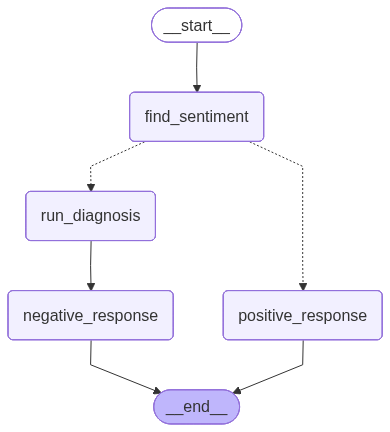

In [43]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [44]:
initail_state = {"review" : "The things are workig well in the website but the ui is not so great"}

final_state = workflow.invoke(initail_state)

In [45]:
final_state

{'review': 'The things are workig well in the website but the ui is not so great',
 'sentiment': 'Negative',
 'diagnosis': {'issue_type': 'UI/UX', 'tone': 'calm', 'urgency': 'low'},
 'response': AIMessage(content="Subject: Thanks for your valuable UI/UX feedback!\n\nHi [User Name],\n\nThank you so much for reaching out and sharing your observations regarding the UI/UX. We truly appreciate you taking the time to provide such thoughtful and clear feedback.\n\nI completely understand how important a smooth and intuitive experience is, and even small design details can significantly impact how you interact with our product. Your insights are incredibly valuable to us as we continuously strive to enhance the user experience.\n\nI've carefully noted down your points and have already forwarded them directly to our UI/UX and development teams for their review. While UI/UX enhancements often require careful planning and consideration, please know that your feedback directly contributes to our o